In [1]:
import astropy
import numpy as np
import matplotlib.pyplot as plt
from astropy.stats import FitnessFunc, bayesian_blocks

In astropy the function `bayesian_blocks` is implemented such that one can either pass a string for the type of data, a fitness function that is an instance of the class `FitnessFunc` or a subclass of `FitnessFunc`.
To implement bayesian blocks with exponential functions we just create a subclass of `FitnessFunc` that implements exponential bounds. This way using the algorithm will be as easy as
```python
edges = bayesian_blocks(t, x, fitness=ExponentialBlocks_Events, p0=0.01)
```

In [2]:
class ExponentialBlocks_Events(FitnessFunc):
    r""" Bayesian Blocks Fitness for binned or unbinned events with piecewise exponential function over the blocks
    
    Parameters
    ----------
    p0 : float, optional
        False alarm probability, used to compute the prior on
        :math:`N_{\rm blocks}` (see eq. 21 of Scargle 2013). For the Events
        type data, ``p0`` does not seem to be an accurate representation of the
        actual false alarm probability. If you are using this fitness function
        for a triggering type condition, it is recommended that you run
        statistical trials on signal-free noise to determine an appropriate
        value of ``gamma`` or ``ncp_prior`` to use for a desired false alarm
        rate.
    gamma : float, optional
        If specified, then use this gamma to compute the general prior form,
        :math:`p \sim {\tt gamma}^{N_{\rm blocks}}`.  If gamma is specified, p0
        is ignored.
    ncp_prior : float, optional
        If specified, use the value of ``ncp_prior`` to compute the prior as
        above, using the definition :math:`{\tt ncp\_prior} = -\ln({\tt
        gamma})`.
        If ``ncp_prior`` is specified, ``gamma`` and ``p0`` is ignored.
    """
    
    def compute_a(self,N_k, T_k, a_0=1):
        """Computes as instructed by eq. C116 in Scargle (2013).
        
        Parameters
        ---------
        N_k : array-like
            number of events in blocks in receding order (from last to first)
        T_k : array-like, float
            length of the blocks in decreasing order
        ---------
        
        Returns
        ---------
        a : array-like
            optimal parameter for each block identified by T_k
        """
        def compute_S_k(T_k,N_k):
            """array of the S variables needed to calculate a as in eq C110 in Scargle (2013) 
            """
            return -(1/N_k)*np.flip(np.cumsum(T_k))
        def compute_Q_k(a,T_k):
            """as above
            """
            return np.exp(-a*T_k)*(1/(1-np.exp(-a*T_k)))
            
        def f(a,T_k,Q_k,S_k):
            """function whose 0 is the a that we need to find
            """
            return (1/a)-T_k*Q_k+S_k
        #initialise the value of a as an array
        if type(a_0)==int:
            a = a_0 * np.ones_like(T_k,dtype=float)
        elif type(a_0)==np.ndarray:
            a=a_0
        else:
            raise ValueError()
        #implementation of Newton's method to find the optimal a
        for i in range(100): #TODO implementare una maniera più intelligente di terminare Newton
            Q_k = compute_Q_k(a,T_k)
            S_k = compute_S_k(T_k,N_k)
            num = f(a,T_k,Q_k,S_k)
            den = -np.power(1/a,2)+T_k*T_k*Q_k*(1+Q_k)
            a -= np.divide(num,den)
        return a
    
    def fitness(self, N_k, T_k):
        # the log (to have additivity of the blocks) of C105 from Scargle (2013)
        #print(N_k,T_k)
        a = self.compute_a(N_k,T_k)
        return np.log(N_k*np.log(np.divide(a*N_k,1-np.exp(-a*T_k)))-a*np.flip(np.cumsum(T_k))-N_k)

In [3]:
N_k=np.array([100,50,100])
T_k=np.array([6,5,4])
##############
t=np.arange(0,100)/30
x=np.abs(np.floor(np.exp(t))+np.random.binomial(10,0.5,100)-5)+1
#print(t)
print(x)
print(bayesian_blocks(t,x,fitness=ExponentialBlocks_Events))

[ 3.  5.  2.  2.  2.  1.  1.  2.  3.  2.  2.  2.  3.  2.  3.  2.  2.  2.
  3.  1.  2.  4.  1.  1.  4.  2.  2.  3.  4.  1.  6.  3.  4.  6.  6.  2.
  3.  6.  4.  6.  4.  4.  5.  7.  4.  7.  4.  5.  5.  8.  8.  7.  6.  7.
 10.  6.  8.  6.  5.  8.  9.  7. 10.  8.  9. 12. 10. 10. 12.  9. 12.  8.
 14. 12. 15. 17. 13. 14. 14. 15. 13. 18. 19. 16. 18. 20. 18. 20. 22. 18.
 23. 23. 24. 21. 23. 24. 26. 27. 26. 28.]


/tmp/ipykernel_2318/66468409.py:49: RuntimeWarning: overflow encountered in exp
  return np.exp(-a*T_k)*(1/(1-np.exp(-a*T_k)))
/tmp/ipykernel_2318/66468409.py:49: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-a*T_k)*(1/(1-np.exp(-a*T_k)))


[0.         0.05       0.08333333 3.3       ]


/tmp/ipykernel_2318/66468409.py:49: RuntimeWarning: overflow encountered in exp
  return np.exp(-a*T_k)*(1/(1-np.exp(-a*T_k)))
/tmp/ipykernel_2318/66468409.py:49: RuntimeWarning: invalid value encountered in multiply
  return np.exp(-a*T_k)*(1/(1-np.exp(-a*T_k)))


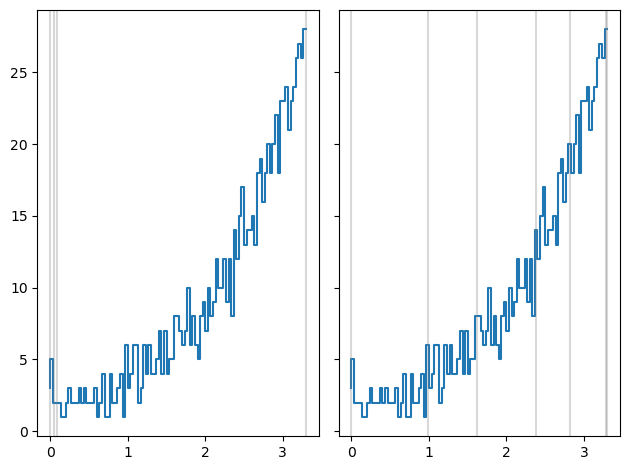

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)

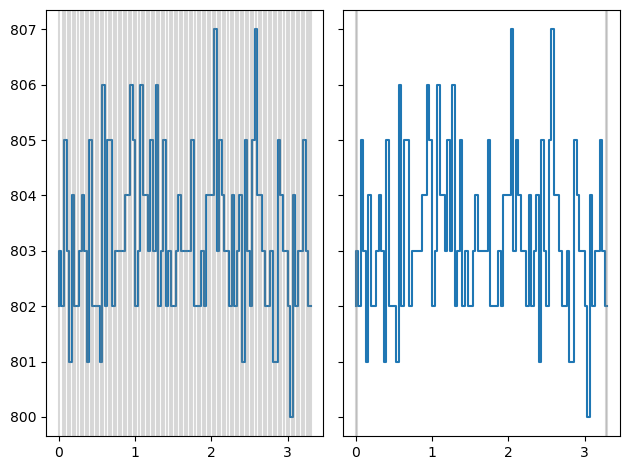

In [5]:
t=np.arange(0,100)/30
x=800+np.random.binomial(10,0.3,100)
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].step(t, x)
axs[1].step(t, x)
xcoords = bayesian_blocks(t,x,fitness=ExponentialBlocks_Events)
for xc in xcoords:
    axs[0].axvline(x=xc, color='grey', alpha=0.3)
xcoords = bayesian_blocks(t,x,fitness='events')
for xc in xcoords:
    axs[1].axvline(x=xc, color='grey', alpha=0.3)